# Machine learning avec les modules Python tensorflow2/keras 

## Entraînement / exploitation d'un réseau de neurones dense pour la reconnaissance de chiffres manuscrits

## La banque d'images MNIST

Dans ce TP nous utilisons les images de la banque MNIST disponible sur Internet (http://yann.lecun.com/exdb/mnist/).

La banque MNIST propose 70000 images en ton de gris de 28 $\times$ 28 pixels, correspondant à des matrice 28 $\times$ 28 de nombres `uint8` (entiers positifs dans l'intervalle [0 ; 255]).<br>
Les 70000 images du MNIST sont regoupées en **60000 images d'apprentissage** et **10000 images de test**.

<div class="alert alert-block alert-danger">
    L'évaluation des performances d'un réseau entraîné doit se faire sur un jeu de données différent du jeu d'entraînement : c'est pour cela que la banque MNIST propose 10000 images de test différentes des 60000 images d'entraînement.
</div>
<p style="text-align:center; font-style:italic; font-size:12px;">
<img src="./img/MnistExamples.png" width="500"><br>
[crédit image : Josef Steppan — Travail personnel, CC BY-SA 4.0, commons.wikimedia.org/w/index.php?curid=64810040)]
</p>

# A/ Quelques rappels utiles...

## Le neurone artificiel
C'est une unité de traitement informatique programmée pour calculer la valeur de sa **fonction d'activation** en un point défini par la **combinaison linéaire de ses entrées** $\sum_i \omega_i x_i - b$ :

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="./img/nn_1.png" width="600" ><br>
    [crédit image : JLC]
</p>

L'entrée *Bias* reçoit le stimuli `-1` affecté du poids $b$ permettant de décaler le point où la fonction d'activation ets calculée.

## Fonction d'activation

Principaux rôles :

- introduire dans le neurone un comportement **non linéaire** (comme des mécanismes de seuil, de saturation...)
- fixer la plage de sortie de la valeur calculée par le neurone, par exemple dans l'intervalle $[-1 ; 1]$, ou $[0 ; +\infty[$

Exemples de fonctions d'activations couramment utilisées :<br />
<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="./img/activationFunctions.png" width="900"><br>
    [crédit image : JLC]
</p>

# B/ Structure du réseau dense à construire 
Dans ce premier TP,  nous allons construire un **réseau dense**, avec :
- une **couche d'entrée** de 784 valeurs comprises entre 0 et 1 (les pixels des image MNIST 28 $\times$ 28 mis sous forme d'un vecteur de 784 nombres `float`),
- une **couche cachée** de 784 neurones utilisant la fonction d'activation `relu`,
- une **couche de sortie** à 10 neurones, pour la classification des images en 10 classes associées aux chiffres {0,1,2...9}, utilisant la fonction d'activation `softmax` adaptée aux problèmes de classification.

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="./img/archiReseau.png" alt="archiReseau.png" style="width: 900px;"><br> 
    [crédit image : JLC]
</p>

Remarques : 
- Chaque neurone de la première couche cachée reçoit 785 entrées : les 784 valeurs $x_i$ des pixels de l'image plus le biais (l'entrée '-1'). 
- $\leadsto$ Il y a donc 785 inconnues pour chaque neurone : les 784 poids $w_i$ affectés à chaque entrée $x_i$, plus le  poids $b$ affecté aux biais.
- $\leadsto$ on compte donc 785 $\times$ 784 inconnues pour la couche cachée et 785 $\times$ 10 inconnues pour la couche de sortie : soit un total de 623290 inconnues dont la valeur doit être optimisée par l'algorithme d'apprentissage du réseau.

### Fonction d'activation softmax

La fonction `softmax` calcule pour chaque neurone de sortie $k$ la valeur $\displaystyle{Y_k = \frac{e^{y_k}}{\sum_i{e^{y_i}}}}$.


`softmax` associe ainsi à chacune des sorties $y_k$ une valeur $Y_k \in [0, 1]$ qui peut être interprétée comme la probablité de la sortie $k$ : on obtient une valeur proche de 1 pour le neurone fournissant la valeur $y_i$ la plus grande, et quasiment 0 pour tous les autres.

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="./img/softmax.png" width="400"><br>
    [crédit image : JLC]
</p>


### Catégorisation des labels (*one-hot coding*)

Les labels des images sont des entiers entre 0 et 9 désignant les chiffres de '0' à '9' alors que la sortie du réseau est un ensemble de 10 valeurs `float` comprises entre 0 et 1 (un vecteur de 10 `float`).<br>
Pour faciliter la comparaison entre le label associé à une image et la sortie du réseau calculée pour cette image, on utilise la catégorisation *one-hot coding* : chaque classe (label) est associée à un vecteur $Y'$ comportant autant d'éléments que de classes à reconnaître : les éléments du vecteur sont tous nuls sauf un, permettant d'identifier de façon unique chacune des classes.<br>

Pour notre exemple des 10 classes correspondant aux labels '0' à '9' :
- le label `0` correspond au vecteur $Y'_1 = [1 0 0 0 0 0 0 0 0 0]$.
- le label `3` correspond au vecteur $Y'_4 = [0 0 0 1 0 0 0 0 0 0]$.
- le label `9` correspond au vecteur $Y'_9 = [0 0 0 0 0 0 0 0 0 1]$.

### Calcul de l'erreur

Pendant la phase d'entraînement du réseau, chaque image en entrée du réseau donne un vecteur de probabilités en sortie (réponse calculée par le réseau) qui peut doit être comparé à la représentation *hot-one* du label associé à l'image d'entrée.

On peut utiliser l'erreur *cross entropy* : $-\sum_i{Y'_i.\log{Y_i}}$ qui mesure l'écart entre la représentation *one-hot* du label et la réponse du réseau :

<p style="text-align:center; font-style:italic; font-size:12px;">
    <img src="./img/CrossEntropy.png" width=600><br>
    (crédit image : vidéo "Deep Learning TensorFlow" de Martin Gorner)
</p>


### Backpropagation error

L'algorithme de **retropropagation de l'erreur** permet de modifier les poids des couches du réseau pour minimiser l'erreur entre valeur attendue et valeur prédite par le réseau. <br>
Au fur et à mesure des apprentissages successifs, les poids du réseau convergent vers un état qui constitue le réseau entraîné.

### Rendre les tirages aléatoires reproductibles

Les poids d'un réseau de neurones sont initialisés par tirage aléatoire ; lorsqu'on invoque plusieurs fois de suite des générateurs aléatoires (comme `numpy.random.rand`...) on constate qu'à chaque invocation, on obtient une suite de valeurs aléatoires différentes :

In [1]:
import numpy as np
print(np.random.rand(5))

[0.97476524 0.24647642 0.8130836  0.44725372 0.69945352]


In [2]:
print(np.random.rand(5))

[0.64708311 0.68928337 0.87936452 0.33675265 0.73172459]


Ceci peut présenter un problème quand on veut étudier les performances d'un réseau entraîné en fonction de paramètres de construction : à chaque fois qu'on relance la cellule ou le notebook avec de nouvelles valeurs des paramètres, on obtient un état initial du réseau différent conduisant à un état du réseau entraîné différent... ce qui peut gêner les comparaisons.

Quand on a besoin d'éviter ce phénomène, on peut fixer la **graine** (*seed*) des générateurs aléatoires de façon à produire des suites de nombres aléatoires **reproductibles**.<br>
Les cellules suivantes illustrent le procédé :

In [3]:
seed = 43

In [4]:
np.random.seed(seed)
np.random.rand(5)

array([0.11505457, 0.60906654, 0.13339096, 0.24058962, 0.32713906])

In [5]:
np.random.seed(seed)
np.random.rand(5)

array([0.11505457, 0.60906654, 0.13339096, 0.24058962, 0.32713906])

# B/ Travail à faire

## Environnement Python de travail

<div class="alert alert-block alert-danger">
<span style="color:brown;font-family:arial;font-size:normal"> 
L'état de l'art actuel des projets de machine learning sous Python préconise de travailler dans un <span style="font-weight:bold;">environnement virtuel Python3</span> qui permet de maîtriser les versions des modules Python "sensibles" (comme tensorflow par exemple) : dans le cas d'un démarrage de l'ordinateur avec une clef USB Ubuntu, on peut considérer que la clef fournit un environnement Python dédié (celui de la clef), à condition de ne pas faire de mises à jour des paquets Python avec <span style="font-style:italic">pip install...</span>
    
Dans le cas contraire, le document <span style="font-style:italic">EnvironnementPython_tf2.pdf</span> explique comment créer un environnement Python dédié pour le travail avec le module tensorflow.
</span>
</div>

### Documentation tensorflow/keras

Le module **keras** qui permet une manipulation de haut niveau des objets **tensorflow** est intégré dans tensorflow2. <br>
La documentation du module **tf.keras** à consulter pour ce TP est ici : https://www.tensorflow.org/api_docs/python/tf/keras. 

Versions des modules Python validées pour ce TP sous Ubuntu 20 / Python3.8.5 :
- tensorflow 2.4.0 incluant tensorflow.keras 2.4.0
- OpenCV 4.2.0

In [6]:
import tensorflow as tf
from tensorflow import keras
import sys, cv2
print(f"Python    : {sys.version.split()[0]}")
print(f"tensorflow: {tf.__version__} incluant keras {keras.__version__}")
print(f"OpenCV    : {cv2.__version__}")

Python    : 3.8.5
tensorflow: 2.4.0 incluant keras 2.4.0
OpenCV    : 4.2.0


Incrustation des tracés matplotlib dans le cahier IPython et import de modules utiles :

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## 1 - Récupération des images MNIST

Consulter la documentation de la fonction `load_data` sur la page [tf.keras.datasets.mnist.load_data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/mnist/load_data) puis compléter la cellule ci-dessous pour charger les données du MNIST en nommant les données renvoyées :<br>
- `im_train`, `im_test` pour les images d'entraînement et de test,
- `lab_train`, `lab_test` pour les labels des données d'entraînement et de test.

In [8]:
(im_train, lab_train), (im_test, lab_test) = tf.keras.datasets.mnist.load_data()

La cellule ci-dessous affiche les attributs `shape` et `dtype` des tableaux numpy obtenus : les valeurs son-elles cohérentes ?

In [9]:
print("im_train:", im_train.shape, im_train.dtype, ", im_test:",im_test.shape, im_test.dtype)
print("lab_train:", lab_train.shape, lab_train.dtype, ", lab_test:",lab_test.shape, lab_test.dtype)

im_train: (60000, 28, 28) uint8 , im_test: (10000, 28, 28) uint8
lab_train: (60000,) uint8 , lab_test: (10000,) uint8


### Visualisation des images et des étiquettes :

Avec la fonction `imshow` du module `matplotlib.pyplot` faire afficher en tons de gris la 601-ème image du tableau `im_train`.<br><br>
Indications :
- utiliser `plt.figure(figsize=(2,2))` pour fixer la taille de l'image
- utiliser l'option `cmap='gray'` de `imshow` pour l'affichage en ton de gris
- enlever les graduations en X et Y avec l'instruction  `plt.xticks([]); plt.yticks([])`.

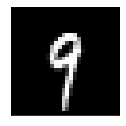

In [10]:
plt.figure(figsize=(2,2))
plt.imshow(im_train[600], cmap='gray')
plt.xticks([]); plt.yticks([]);

Vérifier que l'étiquette associée à `image_train[600]` correspond bien à ce qu'on voir sur l'image....

In [11]:
lab_train[600] == 9

True

Écrire une fonction `plot_images` d'arguments `images, r, L, C` qui affiche les images du tableau `images` (tableau de matrices) dans une grille d'images de `L` lignes et `C` colonnes  en commençant avec l'image de rang `r`. La taille de la figure totale (option`figsize` de `plt.figure`) sera fixée pour que chaque image de la grille soit de taille `(1,1)`.<br>
*Indications* : utiliser `plt.subplot(L,C,n)` pour positionner la nième image dans la grille des L x C images.

In [12]:
def plot_images(images, r,L,C):
    plt.figure(figsize=(C,L))
    for i in range(L*C):
        plt.subplot(L, C, i+1)
        plt.imshow(images[r+i], cmap='gray')
        plt.xticks([]); plt.yticks([])

Faire afficher les images d'entraînement à partir de la 601 ème dans une grille de 4 x 6 :

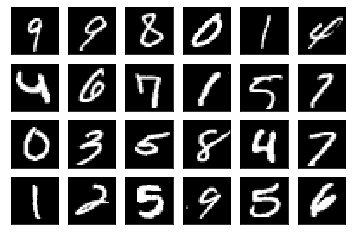

In [13]:
plot_images(im_train, 600, 4, 6)

Faire afficher les images de test à partir de la 601 ème dans une grille de 4 x 6 :

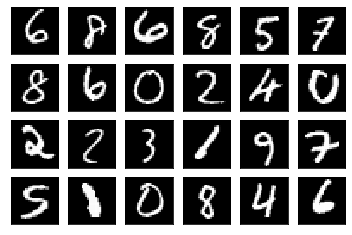

In [14]:
plot_images(im_test, 600, 4, 6)

## 2 - Pré-traitement des données

Pour adapter les données au réseau de neurones, on va transformer les matrice d'entiers `uint8` représentant les images 28 x 28 pixels en vecteurs **normalisés** $(V_i)_{i=0..783}$ de 784 valeurs réelles $V_i$  avec $ 0 \leqslant V_i \leqslant 1.$<br />

*Nota* : une autre façon de faire consisterait à garder les matrices en utilisant l'option de du module **keras** qui permet de dire que la couche d'entrée est constituée de matrices (cf le TP3 qui met en oeuvre un réseau convolutionnel).

### Transformation des matrices d'entrée en vecteurs normalisés :

Pour paramétrer les traitements, on récupère à l'aide des tableaux `im_train` et `im_test` :
- le nombre d'images d'entraînement (`nb_im_train` et `nb_im_test`)
- le nombre de pixels des images (`nb_pixels`)

In [15]:
# compléter la cellule...
nb_im_train = im_train.shape[0]
nb_im_test  = im_test.shape[0]
nb_pixels   = im_train[0].size        
print(f"{nb_im_train} images d'entraînement et {nb_im_test} images de test")
print(f"{nb_pixels} pixels dans chaque image")

60000 images d'entraînement et 10000 images de test
784 pixels dans chaque image


Définir maintenant les tableaux `x_train` et `y_train` contenant les matrices des tableaux `im_train` et `im_test` *mises à plat* sous forme de vecteurs normalisés (valeurs comprises entre 0 et 1).<br>
*indications* : utiliser la méthode `reshape` des tableaux ndarray de numpy et les valeurs de `nb_im_train`, `nb_im_test` et `nb_pixels` :

In [16]:
x_train = im_train.reshape((nb_im_train, nb_pixels))/255
x_test  = im_test.reshape((nb_im_test, nb_pixels))/255

Vérifier visuellement que les dimensions des tableaux `x_train` et `x_test` sont bien celles attendues :

In [17]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

Vérifier que les valeurs min et max des tableaux `x_train` et `x_test` sont bien celles attendues :

In [18]:
x_train.min(), x_train.max()

(0.0, 1.0)

In [19]:
x_test.min(), x_test.max()

(0.0, 1.0)

###  Codage *one-hot*  des labels:

Consulter la page sur la fonction `to_categorical` [tf.keras.utils.to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical), en déduire comment transformer les tableaux `lab_train` et `lab_test` en tableaux `y_train` et `y_test` contenant des vecteurs encodés *hot-one* :

In [20]:
from tensorflow.keras.utils import to_categorical
# 'one-hot' encoding' des labels :
y_train = to_categorical(lab_train)
y_test  = to_categorical(lab_test)

Vérifier visuellement les 10 premières valeurs des tableaux `lab_train` et `y_train` :

In [21]:
lab_train[:10], y_train[:10]

(array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32))

## 3 - Construction du réseau de neurones

On va maintenant construire un réseau de neurones **séquentiel** en **5 lignes** Python à l'aide du module **keras**.

Après lecture de la page [guide/keras/sequential_model](https://www.tensorflow.org/guide/keras/sequential_model), construire le réseau  de manière incrémentalle avec la méthode `add` dans la cellule ci-dessous en suivant la démarche proposée :
- 1- Créer l'objet `model` instance de la classe `Sequential` (cf [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)).
- 2- Les couches du réseau sont des objets de type `Dense` ajoutés à `model` avec la méthode `add`. (cf [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)) <br>
Chaque objet `Dense` est construit avec les arguments propres à sa couche :
    - argument de la couche d'entrée : `keras.Input(shape=(nb_pixels,))`, pour spécifier la forme des données d'entrées.
    - argument de la 1ère couche : `Dense(nb_pixels, activation='relu')`
        - `nb_pixels` neurones dans la couche,
        - `activation='relu'` affecte la fonction d'activation *relu* à tous les neurones de la couche (cf  [tf.keras.activation.relu](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)).
        - la forme des données d'entrée est donnée par la couche précédente.
    - argument de la 2ème couche : `Dense(nb_classes, activation='softmax')`
        - `nb_classes` neurones dans le couche,
        - `activation='softmax'` affecte la fontion d'activation *softmax* à tous les neurones de la couche (cf [tf.keras.activation.softmax](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax))
        - le nombre d'entrées est déduit automatiquement (nombre de neurones de la couche précédente)
- 3- Lancer la méthode `compile` de l'objet `model` en utilisant les arguments :
    - `loss="categorical_crossentropy"` pour choisir la focntion d'erreur entropie croisée (cf [tf.keras.categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy))
    - `optimizer="adam"` pour choisir l'optimiseur Adam (cf page [tf.keras.optimizers.Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam))
    - `metrics=["accuracy"]` qui permettra d'obtenir des données pour tracer les courbes de performance.

In [22]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 

nb_classes = 10
np.random.seed(43)

# les 5 lignes pour construire le réseau de neurones:
model = Sequential()
model.add(keras.Input(shape=(nb_pixels,)))
model.add(Dense(nb_pixels, activation='relu'))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

Avec la méthode `summary` de l'objet `model`, faire afficher la description du modèle : noter les valeurs des paramètres...

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 784)               615440    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 623,290
Trainable params: 623,290
Non-trainable params: 0
_________________________________________________________________


Retrouver le nombre total de paramètres avec une formule simple ...

In [24]:
785*784+785*10

623290

La fonction `plot_model` permet aussi de dessiner la structure du réseau (vor la page [tf.keras.utils.plot_model](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model))

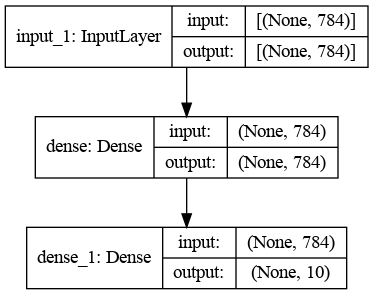

In [25]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Sauvegarde de l'état initial du  réseau

On peut sauvegarder l'état initial des poids du réseau non-entraîné (valeurs aléatoires) avec la méthode `Model.save_weights`. <br>
Ce sera utile plus loin pour remettre le réseau à son état initial avant de relancer d'autres entraînements :

In [26]:
import os

# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("weights"): os.mkdir("weights")

# sauvegarde des poinds du réseau initial:
model.save_weights('weights/initial')

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith("initial")]
for f in files: print(f)

weights/initial.data-00000-of-00001
weights/initial.index


Remarque : la méthode `Model.save_weights` utilise on donne le nom `"initial"`pour créer plusieurs fichiers préfixés par `"initial"`.<br>
Lors de la lecture ultérieure des poids du réseau avec la méthode `Model.load_weights` il suffira de donner le même nom pour que cela fonctionne.

## 4 - Entraînement du réseau

Compléter la cellule ci-dessous pour entraîner le réseau en utilisant la méthode `fit` de l'objet `model` avec les arguments :
- `x_train` : les 60000 images mises à plat et normalisées
- `y_train` : les 60000 labels encodés *one-hot*.
- `epochs=15` : faire 15 fois l'entraînement complet.
- `batch_size=128` : découper le jeu des données d'entrée (les 60000 images) en "lots" (*batch*) de taille `batch_size`.<br>
La mise à jour des poids du réseau est faite au bout de `batch_size` échantillons d'entrée. La valeur de `batch_size` (par défaut est 32) est un paramètre qui influe beaucoup sur la qualité de l'apprentissage : on peut essayer d'autres valeurs (64, 128 ...) et observer comment évoluent les performances d'entraînement).

Consulter au besoin la documentation de la méthode `fit` dans la page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

In [27]:
# au cas on on exécute plusieurs fois cette cellule, il faut ré-initialiser 
# les poids du réseau à leur valeur initiale si on veut comparer les entraînements...
model.load_weights("weights/initial") 

hist = model.fit(x_train, y_train, 
                 epochs=15, 
                 batch_size=128)

Epoch 1/15
469/469 [==============================] - 4s 8ms/step - loss: 0.4243 - accuracy: 0.8787
Epoch 2/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1007 - accuracy: 0.9708
Epoch 3/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0620 - accuracy: 0.9816
Epoch 4/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0418 - accuracy: 0.9879
Epoch 5/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0276 - accuracy: 0.9922
Epoch 6/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0208 - accuracy: 0.9942
Epoch 7/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0149 - accuracy: 0.9962
Epoch 8/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0112 - accuracy: 0.9974
Epoch 9/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0079 - accuracy: 0.9980
Epoch 10/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0083 - accuracy: 0.9980

L'objet `hist` retourné par la méthode `fit` possède un attribut `history` de type dictionnaire dont les clefs `'loss'` et `'accuracy'` contiennent l'évaluation de la perte et de de précision du réseau entraîné après chaque 'époque ' (*epoch*) :

In [28]:
hist.history.keys()

dict_keys(['loss', 'accuracy'])

In [29]:
hist.history['loss']

[0.24268075823783875,
 0.09591134637594223,
 0.060549333691596985,
 0.04261237010359764,
 0.029204851016402245,
 0.021765494719147682,
 0.016506554558873177,
 0.012231728993356228,
 0.009999698959290981,
 0.008289005607366562,
 0.008257333189249039,
 0.006903486791998148,
 0.004794485401362181,
 0.009174673818051815,
 0.004951515235006809]

In [30]:
hist.history['accuracy']

[0.9302666783332825,
 0.9719833135604858,
 0.9818333387374878,
 0.9873499870300293,
 0.9914000034332275,
 0.9936833381652832,
 0.9955333471298218,
 0.996833324432373,
 0.9972333312034607,
 0.9978833198547363,
 0.9975833296775818,
 0.9981333613395691,
 0.9988333582878113,
 0.9971666932106018,
 0.9986666440963745]

### Tracé des courbes `accuracy` et `loss` :

La fonction `plot_loss_accuracy` du module `utils.tools` (présent dans le répertoire du notebook) permet de tracer les courbes de précision et de perte en utilisant les données stockées dans l'objet `hist` :

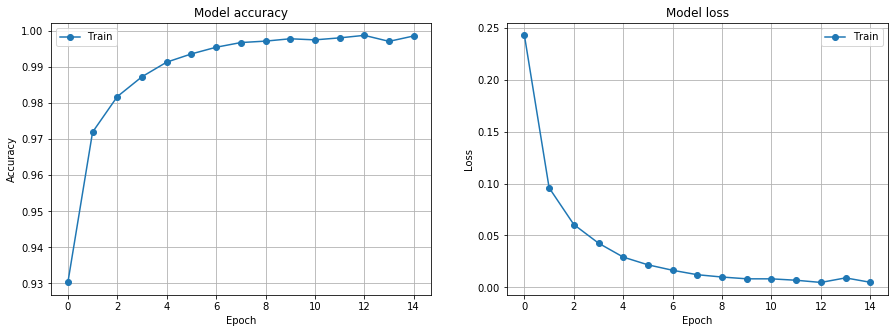

In [31]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

## 5 - Entraînement du réseau avec test à chaque `epoch`

Pour avoir un indicateur réaliste de la qualité du réseau entraîné on peut tester à chaque `epoch` la précison du réseau entraîné en utilisant les données de test : il suffit de passer l'agument `validation_data` à la méthode `fit`, en lui affectant le tuple des données de test `(x_test, y_test)`

In [32]:
model.load_weights("weights/initial")

hist = model.fit(x_train, y_train,
                 validation_data=(x_test, y_test), 
                 epochs=15, 
                 batch_size=128)

Epoch 1/15
469/469 [==============================] - 4s 8ms/step - loss: 0.1933 - accuracy: 0.9416 - val_loss: 0.0929 - val_accuracy: 0.9718
Epoch 2/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0715 - accuracy: 0.9786 - val_loss: 0.0745 - val_accuracy: 0.9771
Epoch 3/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0450 - accuracy: 0.9863 - val_loss: 0.0613 - val_accuracy: 0.9800
Epoch 4/15
469/469 [==============================] - 3s 7ms/step - loss: 0.0297 - accuracy: 0.9916 - val_loss: 0.0577 - val_accuracy: 0.9811
Epoch 5/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0201 - accuracy: 0.9946 - val_loss: 0.0622 - val_accuracy: 0.9803
Epoch 6/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0144 - accuracy: 0.9966 - val_loss: 0.0532 - val_accuracy: 0.9835
Epoch 7/15
469/469 [==============================] - 4s 8ms/step - loss: 0.0095 - accuracy: 0.9978 - val_loss: 0.0576 - val_accuracy: 0.9835
Epoch 

On a cette fois dans l'objet `hist` non seulement les clefs `loss` et `accuracy` mais aussi `val_loss` et `val_accuracy` calculées en faisant tourner le réseau à chaque `epoch` avec les données de test :

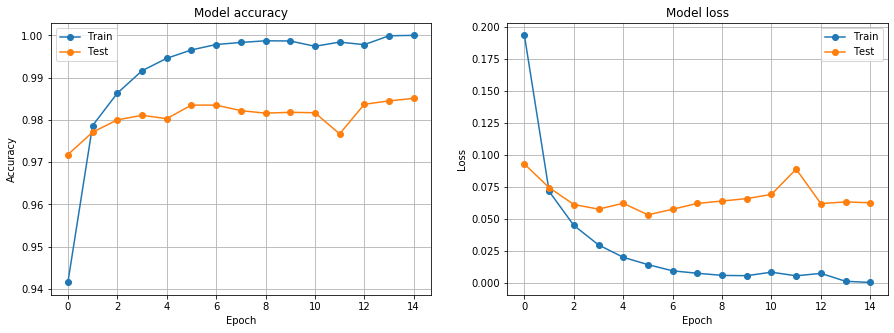

In [33]:
from utils.tools import plot_loss_accuracy
plot_loss_accuracy(hist)

On voit que la précision calculée avec les données de test tend vers une limite voisine de 98%. <br>
On pourrait penser qu'augmenter la valeur de `epochs` permet d'améliorer la précision du réseau... mais on court le risque de sur-entraînner le réseau (*over-fit*).

### Arrêter l'entraînement avant *over-fit*

Keras propose des mécanismes permettant d'arrêter automatiquement l'apprentissage en surveillant par exemple la croissance de la précision d'une `epoch` à l'autre. Ce point est traité dans le notebook `TP2_MNIST_dense_overfit.ipynb`.

### Sauvegarder les poids du  réseau entraîné

La méthode `Model.save_weights` permet d'enregistrer les **poids** du réseau entraïné dans un fichier :

In [34]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("weights"): os.mkdir("weights")

# sauvegarde des poids du réseau entrainé:
model.save_weights('weights/check_points')

# afficher les fichiers créés:
files=[os.path.join("weights",f) for f in os.listdir("weights") if f.startswith("check")]
for f in files: print(f)

weights/checkpoint
weights/check_points.data-00000-of-00001
weights/check_points.index


### Sauvegarder la structure du réseau et ses poids

La méthode `Model.save` permet d'enregistrer **toute la structure et les poids** du réseau entraïné dans un fichier.<br />
Ceci permet de recréer plus tard *from scratch* le réseau entrainé pour passer en phase exploitation du réseau par exemple, en utilisant la fonction`tf.keras.models.load_model` :

In [35]:
import os
# vérifier que le dossier 'weights' existe et sinon le créer:
if not os.path.exists("models"): os.mkdir("models")

# sauvegarder structure réseau + poids :
model.save('models/model1') 

# afficher les fichiers créés:
files=[os.path.join("models",f) for f in os.listdir("models") if f.startswith("model")]
for f in files: print(f)

INFO:tensorflow:Assets written to: models/model1/assets
models/model1


## 6/ Exploitation du réseau avec le jeu de test

La méthode `predict` de l'objet `model` permet de calculer la prédiction du réseau pour une ou plusieurs entrées (voir la méthode `predict`dans la page [tf.keras.Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential)).

La cellule ci-dessous montre la mise en oeuvre de la méthode `predict`, et comment exploiter la représentation  *one-hot* renvoyée par `fit` en utilisant la méthode `argmax` des tableaux de numpy :

sortie du réseau pour l'image de rang 100 :
[4.1557211e-08 1.4845161e-10 5.2440180e-10 7.3660609e-12 1.0376212e-10
 9.4466623e-10 1.0000000e+00 1.4716485e-11 1.7507069e-09 9.6762398e-13]

sortie réseau arrondie à 1 chiffre : [0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0]
rep[0].argmax() donne : 6

La bonne réponse est 6 soit en 'hot-one' : [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


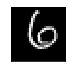

In [36]:
i = 100   # numéro image de test
rep = model.predict(x_test[i:i+1]) # Attention: x doit être un tableau de matrices...
                                   # => x[i] ne convient pas !

print(f"sortie du réseau pour l'image de rang {i} :\n{rep[0]}")

# limiter l'affichage des composantes des tableaux numpy à 1 chiffre :    
with np.printoptions(formatter={'float':'{:.1f}'.format}):    
    print(f"\nsortie réseau arrondie à 1 chiffre : {rep[0]}")
    
print(f"rep[0].argmax() donne : {rep[0].argmax()}")

print(f"\nLa bonne réponse est {lab_test[i]} soit en 'hot-one' : {y_test[i]}")

plot_images(im_test,i,1,1)

Compléter la cellule ci-dessous pour calculer le pourcentage d'erreur du réseau entrainé en utilisant les données de test :

In [37]:
results = model.predict(x_test)
success = 0
for i, res in enumerate(results):
    success += (res.argmax() == lab_test[i])
print(f"taux de réussite : {success/len(x_test)*100:.2f} %")

taux de réussite : 98.51 %


###  Afficher la matrice de confusion

La cellule suivante définie la fonction `show_cm` qui affiche la **matrice de confusion** :

In [38]:
import pandas as pd
from seaborn import heatmap
from sklearn.metrics import confusion_matrix

def show_cm(target, results, classes):
    # y : actual answers (vector of int)
    # results : the trained network answers
    # classes : the liste of possible answers
    predicted = np.argmax(results, axis=-1) # tableau d'entiers entre 0 et 9 (argmax de chaque vecteur 'one-shot')

    cm = confusion_matrix(target, predicted)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(11,9))
    heatmap(df_cm, annot=True);

L'affichage de la matrice de confusion permet de visualiser :
- sur la diagonale : les bonnes réponses du réseau, avec dans chaque case le nombre de bonne réponses
- hors diagonale : les erreurs du réseau, avec dans chaque case la fréquence d'apparition de l'erreur.

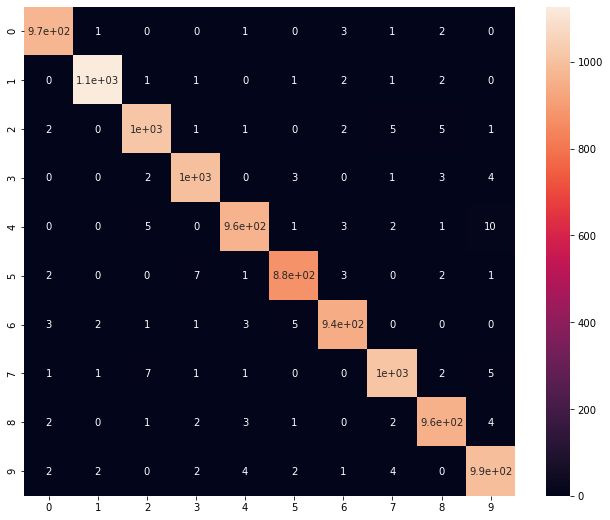

In [39]:
show_cm(lab_test, results, range(10))

## 7/ Évolution du réseau : augmentation du nombre de couches cachées 

On peut essayer de construire un réseau avec plus de couches. Par exemple :
- couche d'entrée avec les 784 pixels
- couche cachée 1 : 784 neurones, fonction d'activation `relu`
- couche cachée 2 : 300 neurones, fonction d'activation `relu`
- couche cachée 3 : 100 neurones, fonction d'activation `relu`    
- couche de sortie : 10 neurone, fonction d'activation `softmax`.

Compléter la cellule ci-dessous pour construire le réseau `model2` :

In [40]:
np.random.seed(43)

model2 = Sequential()
model2.add(keras.Input(shape=(nb_pixels,)))
model2.add(Dense(784, activation='relu'))
model2.add(Dense(300, activation='relu'))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(10, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Faire afficher la description du modèle avec la méthode `summary` :

In [41]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 784)               615440    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 882,050
Trainable params: 882,050
Non-trainable params: 0
_________________________________________________________________


Dessiner la structure du réseau avec aa fonction `plot_model` :

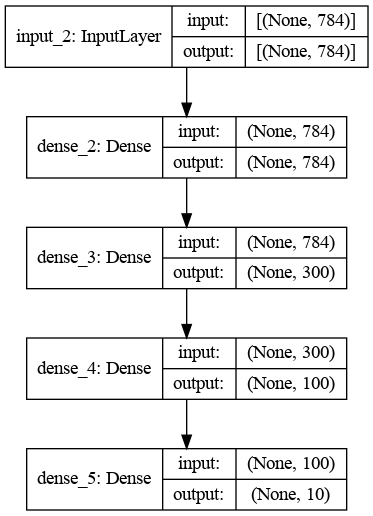

In [42]:
tf.keras.utils.plot_model(model2, show_shapes=True)

Entraîner le réseau `model2` avec les mêmes données que `model` (avec test à chaque `epoch`) et faire tracer les courbes de précision et d'erreur :

In [43]:
hist2 = model2.fit(x_train, y_train, 
                   validation_data=(x_test, y_test), 
                   epochs=15, 
                   batch_size=128)

Epoch 1/15
469/469 [==============================] - 6s 12ms/step - loss: 0.3944 - accuracy: 0.8813 - val_loss: 0.0993 - val_accuracy: 0.9683
Epoch 2/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0794 - accuracy: 0.9762 - val_loss: 0.0888 - val_accuracy: 0.9729
Epoch 3/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0515 - accuracy: 0.9830 - val_loss: 0.0919 - val_accuracy: 0.9734
Epoch 4/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0359 - accuracy: 0.9878 - val_loss: 0.0729 - val_accuracy: 0.9793
Epoch 5/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0293 - accuracy: 0.9900 - val_loss: 0.0875 - val_accuracy: 0.9746
Epoch 6/15
469/469 [==============================] - 5s 11ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 0.0674 - val_accuracy: 0.9813
Epoch 7/15
469/469 [==============================] - 5s 12ms/step - loss: 0.0197 - accuracy: 0.9934 - val_loss: 0.0810 - val_accuracy: 0.9795

Faire tracer les courbes 'Model loss' et 'Model accuracy'...

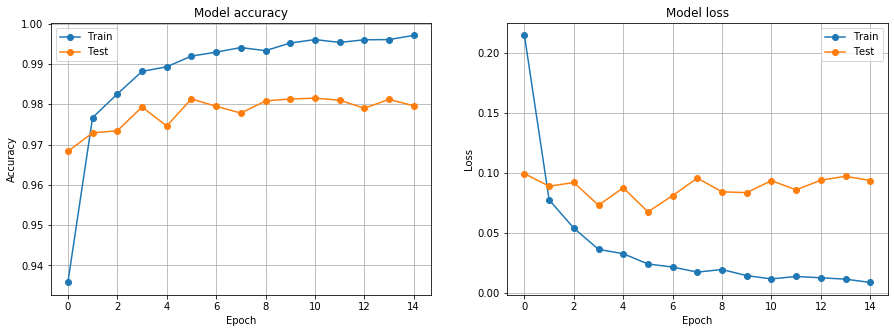

In [44]:
plot_loss_accuracy(hist2)

Faire afficher la matrice de confusion pour les résulats prédits par le réseau `model2` :

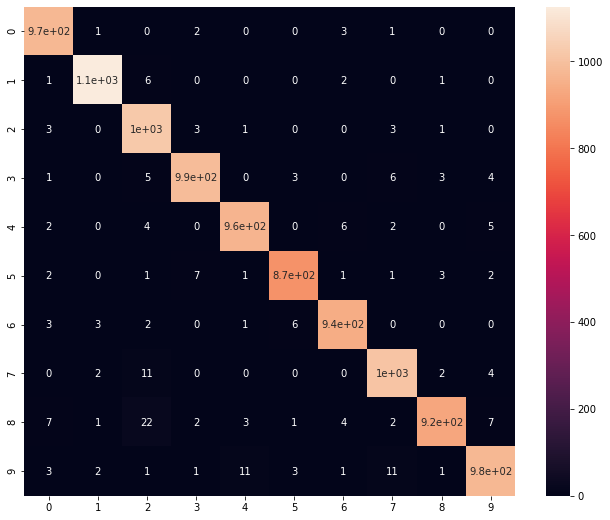

In [45]:
results2 = model2.predict(x_test)
show_cm(lab_test, results2, range(10))

Augmenter le nombre de couches a t'il un impact sur les performances du réseau ?<br />
Que peut on conclure sur l'utilité de complexifier ce type de réseau ?

Double-clic ici pour inscrire ta réponse : on reste voisin des 98 %... pour des temps d'entraînement plus long  => ce n'est pas utile de complexifier le réseau.

# 7/ Exploiter le réseau avec ses propres images

On va maintenant utiliser le réseau entrainé pour voir comment il se comporte avec des chiffres "écrits à la main" différents des chiffres de la banque MNIST...<br>

Pour cela on peut utiliser :
- des images crées par vous-même pour l'occasion... 
- les images du répertoire `chiffres`.

Si vous créez vos propres images, changez le nom du dossier `images_dir` dans la cellule ci-dessous :

In [46]:
import os

# changer le nom du répertoire au besoin :
images_dir = "chiffres"

images = [os.path.join(images_dir,f) for f in os.listdir(images_dir) if f.endswith(".png")]
images.sort()

print("Images du dossier 'chiffres' :")
for im in images: print(im)

Images du dossier 'chiffres' :
chiffres/0.png
chiffres/1.png
chiffres/2.png
chiffres/3.png
chiffres/4.png
chiffres/5.png
chiffres/6.png
chiffres/7.png
chiffres/8.png
chiffres/9.png


### Lecture des fichiers image avec openCV

Les images doivent être convertie en image en ton de gris de 28 x 28 pixels pour pouvoir être traitées par le réseau `model`.

Plusieurs fonction du module OpenCV peuvent être utilisées :
- `cv2.imread` : permet de lire un fichier image aux formats standards (PNG, JPG,...)
- `cv2.cvtColor` : pour convertir une image lue par `cv2.imread` en tons de gris
- `cv2.resize` : pour retailler l'image à 28 x 28 pixels.

La cellule ci-dessous montre un exemple de lecture et traitement avec OpenCV des images du dossier `images_dir` :

In [47]:
import cv2
wanted_shape = (28,28)
my_images = []
for image_path in images:
    img = cv2.imread(image_path)                    # lecture fichier image
    if img.shape != wanted_shape: cv2.resize(img, wanted_shape)
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # conversion en tons de gris
    my_images.append(img_gray)

Visualisation des images lues :

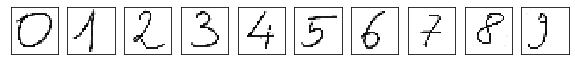

In [48]:
plot_images(my_images, 0, 1, 10)

Inversion des images pour avoir des chiffres doivent être en blanc sur fond noir :

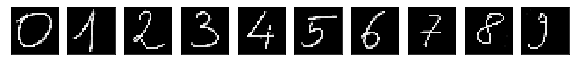

In [49]:
my_images = [255 - im for im in my_images]
plot_images(my_images, 0, 1, 10)

On peut maintenant transformer des matrices 28x28 en vecteurs de float normalisés :

In [50]:
my_images = np.array(my_images)
nb_images = my_images.shape[0]

# mise 'à plat' des matrices sous forme de vecteurs de floats normalisés :
x_data = my_images.reshape(nb_images, 28*28)/255.

prédiction du réseau entrainé, avec les images perso :

In [51]:
results1 = model.predict(x_data)
results1.argmax(axis=-1)

array([2, 1, 2, 3, 4, 5, 6, 7, 8, 3])

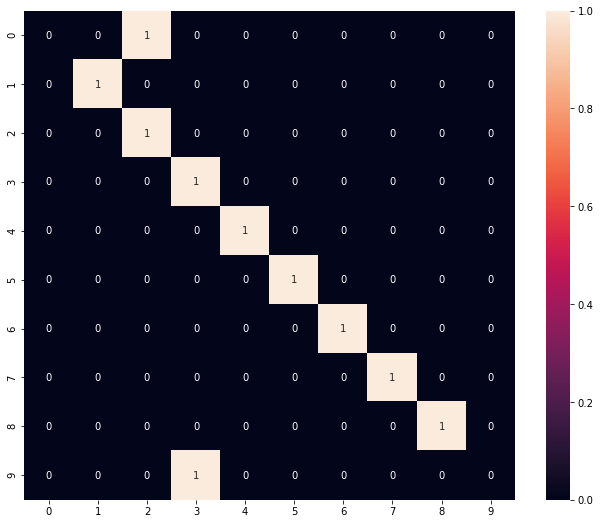

In [52]:
target    = np.array([0,1,2,3,4,5,6,7,8,9])
show_cm(target, results1, range(10))

Avec le deuxième réseau dense :

In [53]:
results2 = model2.predict(x_data)
results2.argmax(axis=-1)

array([0, 1, 2, 3, 4, 5, 6, 2, 0, 1])

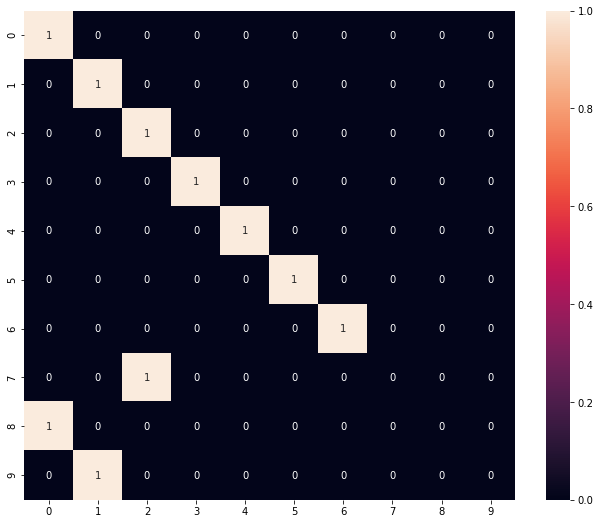

In [54]:
target    = np.array([0,1,2,3,4,5,6,7,8,9])
show_cm(target, results2, range(10))

beaucoup mieux ?

Les résultats montrent :
- que le réseau à 1 seule couche cachée et à 2 couches cachées donnent des performances proches pour les images MNIST,
- que l'apprentissage d'un réseau dense reste assez sensible à la nature du jeu de données : les images de chiffres faites 'maison' ne ressemblent pas tout à fait à celles de la banque MNIST, d'où des erreurs de classification avec un simple réseau dense.

# La suite....

Pour aller au-delà des 98% de reconnaissance des chiffres, il faut passer à une autre architecture de réseau plus adaptée au traitement des images : les réseaux **convolutionnels**, traités dans le notebook `TP3_MNIST_convol.ipynb`.

# Autres ressources intéressantes... des vidéos :

In [55]:
%%HTML
<iframe src="https://www.youtube.com/embed/trWrEWfhTVg" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [56]:
%%HTML
<iframe src="https://www.youtube.com/embed/aircAruvnKk" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [57]:
%%HTML
<iframe src="https://www.youtube.com/embed/IHZwWFHWa-w" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

In [58]:
%%HTML
<iframe src="https://www.youtube.com/embed/Ilg3gGewQ5U" width="800" height="450" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>